**Creating a folder where we can save the newly uploaded images from the web page or the database**

In [41]:

import os
folder_path = '/content/new_images'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder '/content/new_images' already exists.


In [42]:
!pip install flask-ngrok

Installing required libraries


In [43]:
import sqlite3
from PIL import Image
import io
import pandas as pd
import matplotlib.pyplot as plt

Downloading the data from the git repository where the database is stored after updation


In [45]:
!git clone https://github.com/aarthi03/MediCaption.git

Cloning into 'MediCaption'...
remote: Enumerating objects: 3092, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 3092 (delta 23), reused 72 (delta 7), pack-reused 2981
Receiving objects: 100% (3092/3092), 1.61 GiB | 44.29 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Updating files: 100% (2958/2958), done.


In [46]:
import shutil
shutil.copy('/content/Test/Updated_DB.db', '/content/Updated_DB.db')

'/content/Updated_DB.db'

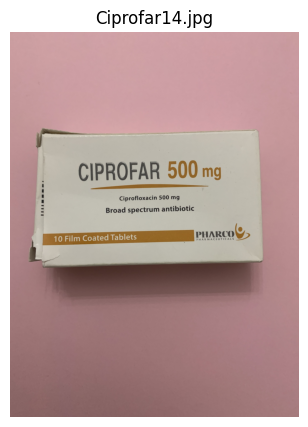

In [47]:
conn = sqlite3.connect('/content/Updated_DB.db')
cursor = conn.cursor()

# Create the images table if it doesn't exist
cursor.execute('''CREATE TABLE IF NOT EXISTS images (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    filename TEXT,
                    data BLOB
                )''')
conn.commit()

# Retrieving image data from the database
cursor.execute("SELECT * FROM images")
rows = cursor.fetchall()

# Creating a list to store image data
image_data = []
for row in rows:
    filename, data = row[1], row[2]
    image = Image.open(io.BytesIO(data))
    image_data.append({'filename': filename, 'image': image})

# Close the database connection
conn.close()

#Creating dataframe to contain the images
df = pd.DataFrame(image_data)

# Display images from the dataframe
if len(df) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(df['image'][0])
    ax.set_title(df['filename'][0])
    ax.axis('off')
else:
    fig, axes = plt.subplots(1, len(df), figsize=(15, 5))

    for i, row in df.iterrows():
        axes[i].imshow(row['image'])
        axes[i].set_title(row['filename'])
        axes[i].axis('off')

plt.show()

In [48]:
!pip install ultralytics

Cloning the YOLO V8 model GIT repository


In [49]:
!git clone https://github.com/ultralytics/ultralytics
!cd ultralytics
!pip install -e ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 22753, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 22753 (delta 10), reused 12 (delta 4), pack-reused 22722
Receiving objects: 100% (22753/22753), 13.49 MiB | 23.61 MiB/s, done.
Resolving deltas: 100% (15922/15922), done.
Obtaining file:///content/Test/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.1.24-0.editable-py3-none-any.whl size=22677 sha256=2d85a54aec4d4956b53549da136e927156da048bdf47d86cf7c499c3270f9027
  Stored in directory: /tmp/pip-ephem-wheel-cache-oq209oss/wheels/84/ce/b0/42f627a7495a2bd3307c0bb8e3bbf9e39460ed895356114e9f
Successfully built ultralytics
  Atte

Saving the images into dataframe created from the database. This DF will help us extract the image from database into the destination filder path.

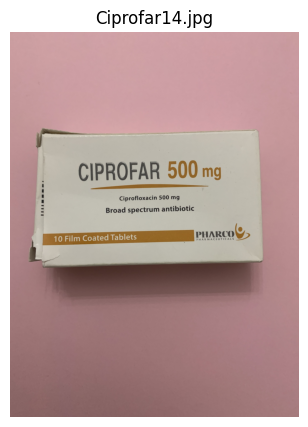

In [50]:
import sqlite3
from PIL import Image
import io
import pandas as pd
import matplotlib.pyplot as plt

# Connecting to the SQLite database
conn = sqlite3.connect('Updated_DB.db')
cursor = conn.cursor()

# Retrieve image data from the database
cursor.execute("SELECT * FROM images")
rows = cursor.fetchall()

# Create a list to store image data
image_data = []
for row in rows:
    filename, data = row[1], row[2]
    image = Image.open(io.BytesIO(data))
    image_data.append({'filename': filename, 'image': image})

# Close the database connection
conn.close()

df = pd.DataFrame(image_data)
if len(df) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(df['image'][0])
    ax.set_title(df['filename'][0])
    ax.axis('off')
else:
    fig, axes = plt.subplots(1, len(df), figsize=(15, 5))

    for i, row in df.iterrows():
        axes[i].imshow(row['image'])
        axes[i].set_title(row['filename'])
        axes[i].axis('off')

plt.show()

In [51]:
import os

output_directory = '/content/new_images'

os.makedirs(output_directory, exist_ok=True)

for i, row in df.iterrows():
    output_file_path = os.path.join(output_directory, row['filename'])
    row['image'].save(output_file_path)
    print(f"Image saved: {output_file_path}")

Image saved: /content/new_images/Ciprofar14.jpg


Predicting the bounding boxes for the medicine image uploaded in the new images folder where the model predicting the labels probability is equal to or greater than 60%


In [52]:
!yolo predict model=/content/Test/best.pt source='/content/new_images' save_crop conf=0.6

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (AMD EPYC 7B12)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

image 1/1 /content/new_images/Ciprofar14.jpg: 640x480 1 Medicine Name, 913.7ms
Speed: 13.3ms preprocess, 913.7ms inference, 32.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/ultralytics/runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [53]:
!pip install easyocr
import easyocr
from PIL import Image


In [54]:
reader = easyocr.Reader(['en'])

Defining the OCR function to extract the text from the images.

In [55]:
def ocrfunc(img):
  text = reader.readtext(img)
  return text[0][1]

In [56]:
import os
import matplotlib.pyplot as plt

In [57]:

folder_path = '/content/ultralytics/runs/detect/predict/crops/Medicine Name/'
items_list = []
cropped_images_list = []
fname = []

files = os.listdir(folder_path)

In [58]:
image_list = []

Displaying the images and extracted text to check if the extraction is done properly or not


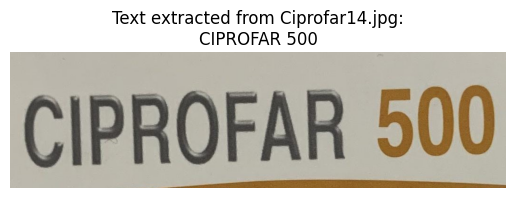

In [59]:
# Loop through each file in the folder
del items_list
del cropped_images_list
cropped_images_list = []
items_list = []
for file_name in files:
    if file_name.endswith('.png') or file_name.endswith('.jpg'):
        # Construct the full path to the image file
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)

        # Perform OCR on the image
        text1 = ocrfunc(image)
        # Initialize an empty list
        cropped_images_list.append(image_path)
        image_list.append(image)
        fname.append(file_name)

        items_list.append(text1)
        # Display the image and extracted text
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Text extracted from {file_name}:\n{text1}")
        plt.show()

In [ ]:
import re

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove leading and trailing whitespace
    text = text.strip()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters (if any)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text


In [60]:
ppr_text_list = []
processed_text =''
for med in items_list:
      processed_text = preprocess_text(med )
      ppr_text_list.append(processed_text)

In [ ]:
ppr_text_list

['ciprofar ']

In [61]:
cropped_images_list


['/content/ultralytics/runs/detect/predict/crops/Medicine Name/Ciprofar14.jpg']

In [62]:
assert len(cropped_images_list) == len(ppr_text_list) #checking if Lists must have the same length"

In [63]:
# Iterate over both lists simultaneously
for image, narray, text in zip(image_list, cropped_images_list, ppr_text_list):

    print("Image:", image)
    print("Extracted Text:", text)
    print("-" * 20)

Image: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1050x287 at 0x7BFCF587AC50>
Extracted Text: ciprofar 
--------------------


Installing further required libraries and packages


In [64]:
!pip install pandas
!pip install fuzzywuzzy
!pip install transformers
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
!pip install gtts
from gtts import gTTS
import pandas as pd
from gtts import gTTS
import os
import csv
import difflib
from fuzzywuzzy import process
df = pd.read_csv('/content/Test/mergedfiltered.csv')

In [65]:
ppr_text_df = pd.DataFrame(ppr_text_list)
fname_df = pd.DataFrame(fname)

In [66]:
correct_name_list = []

In [67]:
merged_df = pd.merge(ppr_text_df, fname_df, left_index=True, right_index=True, how='inner')
merged_df = merged_df.rename(columns={'0_x': 'incorrect_name', '0_y': 'file_name'})

Matching the names with the medicine names in the column of the merged csv file that we ave generated which consists of the medicine details


In [68]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/content/Test/mergedfiltered.csv')

incorrect_medicine_names = ppr_text_list

# Dictionary to store best matches
matches = {}
matches_filename = {}
corrected_filename_mapping = {}

threshold = 90
correct_name_list = []
for incorrect_name in incorrect_medicine_names:
    # Using fuzzy matching to find the best match
    match_tuple = process.extractOne(incorrect_name, df['Name'])
    match = match_tuple[0]
    score = match_tuple[1]

    if score >= threshold:
        matches[incorrect_name] = match


# Print the matches
for incorrect_name, correct_name in matches.items():
    correct_name_list.append(correct_name)
    print(f"Incorrect Name: {incorrect_name} --> Correct Name: {correct_name}")


Incorrect Name: ciprofar  --> Correct Name: Ciprofar


In [69]:
# Define an empty dictionary to store matches
matches = {}

# Iterate over the list of incorrect medicine names
for incorrect_name in incorrect_medicine_names:
    match_tuple = process.extractOne(incorrect_name, df['Name'])
    match = match_tuple[0]
    score = match_tuple[1]

    if score >= threshold:
        # Store the correct match for the incorrect name
        matches[incorrect_name] = {
            'correct_name': match,
            'file_paths': []
        }

for incorrect_name, match_data in matches.items():
    # Filter merged_df for rows where 'incorrect name' matches incorrect_name
    matching_rows = merged_df[merged_df['incorrect_name'] == incorrect_name]


    paths = matching_rows['file_name'].tolist()
    matches[incorrect_name]['file_paths'].extend(paths)

# Print the matches along with respective file paths
for incorrect_name, match_data in matches.items():
    correct_name = match_data['correct_name']
    file_paths = match_data['file_paths']

    print(f"Incorrect Name: {incorrect_name} --> Correct Name: {correct_name}")
    print(f"Associated File Paths: {file_paths}")

Incorrect Name: ciprofar  --> Correct Name: Ciprofar
Associated File Paths: ['Ciprofar14.jpg']


In [70]:
corrected_files = {}

# Iterate over the items in the matches dictionary
for incorrect_name, match_data in matches.items():
    correct_name = match_data['correct_name']
    file_paths = match_data['file_paths']

    if correct_name in corrected_files:
        corrected_files[correct_name].extend(file_paths)
    else:
        corrected_files[correct_name] = file_paths

# Create lists to store corrected names and associated file paths
corrected_name_list = []
file_paths_list = []

for correct_name, file_paths in corrected_files.items():
    corrected_name_list.append(correct_name)
    file_paths_list.append(file_paths[0])

# Create a dictionary from the lists
data = {'Corrected_Name': corrected_name_list, 'File_Path': file_paths_list}

# Convert the dictionary to a DataFrame
df_corrected_files = pd.DataFrame(data)

print(df_corrected_files)

  Corrected_Name       File_Path
0       Ciprofar  Ciprofar14.jpg


In [71]:

from transformers import GPT2LMHeadModel, GPT2Tokenizer

df1 = pd.DataFrame()
# Selective columns to copy from df1 to df2
columns_to_copy = ['Name', 'Uses','GENERIC NAME(S)', 'Side Effects', 'Dosage Limit']

# Copy selected columns from df1 to df2
for col in columns_to_copy:
    df1[col] = df[col]

Based on the medicine name , the detials for the medicine are given as put put which is asved in both pdf and .mp3 format which can be given as the output.


In [72]:
medicine_info = pd.merge(df, df_corrected_files, left_on='Name', right_on='Corrected_Name', how='inner')

Medicine Information:
- Name: Ciprofar
- Generic Name(s): Ciprofloxacin
- Uses: Treating bacterial infections such as urinary tract infections, respiratory tract.
- Side Effects: Nausea, vomiting, diarrhea, Headache, dizziness, Photosensitivity.




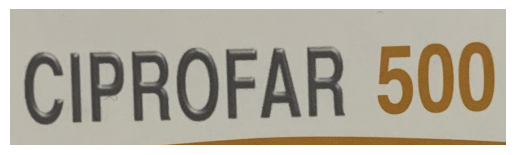

In [73]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

output_text = ""
full_output_for_mp3 = ''

if not medicine_info.empty:
    for index, row in medicine_info.iterrows():
      output_text = ""
      output_text += f"Medicine Information:\n"
      output_text += f"- Name: {row['Name']}\n"
      output_text += f"- Generic Name(s): {row['GENERIC NAME(S)']}\n"
      output_text += f"- Uses: {row['Uses']}\n"
      output_text += f"- Side Effects: {row['Side Effects']}\n"
      # Display images associated with file names
      file_name = row['File_Path']
      image_path = f"//content/ultralytics/runs/detect/predict/crops/Medicine Name/{file_name}"
      img = Image.open(image_path)
      output_text += "\n"
      full_output_for_mp3 += output_text
      print(output_text)
      plt.imshow(img)
      plt.axis('off')
      plt.show()


In [75]:
processed_text = preprocess_text(full_output_for_mp3 )
full_output_for_mp3 = full_output_for_mp3.replace('\n', '')

In [74]:
full_output_for_mp3
# Convert text to speech
tts = gTTS(text=full_output_for_mp3, lang='en')
tts.save("output.mp3")

# Play the audio file
os.system("open output.mp3")

768

Saving the output in the form of PDF for future references. This file will be addded to the database of the user.


In [76]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from PIL import Image

# Create a PDF file
pdf_file_path = 'medicine_info_output.pdf'
with PdfPages(pdf_file_path) as pdf:

    # Loop through each row in the medicine_info DataFrame
    for index, row in medicine_info.iterrows():
        output_text = ""
        output_text += f"Medicine Information:\n"
        output_text += f"- Name: {row['Name']}\n"
        output_text += f"- Generic Name(s): {row['GENERIC NAME(S)']}\n"
        output_text += f"- Uses: {row['Uses']}\n"
        output_text += f"- Side Effects: {row['Side Effects']}\n"

        # Display images associated with file names
        file_name = row['File_Path']
        image_path = f"/content/ultralytics/runs/detect/predict/crops/Medicine Name/{file_name}"  # Update the path to your images
        img = Image.open(image_path)

        fig, ax = plt.subplots(figsize=(8, 6))

        ax.imshow(img)
        ax.axis('off')

        text_x = 10
        text_y = img.height + 20

        ax.text(text_x, text_y, output_text, fontsize=12, ha='left', va='top', wrap=True)

        # Save the figure to the PDF
        pdf.savefig(fig, bbox_inches='tight')

        # Close the figure
        plt.close(fig)

print(f"PDF file saved to: {pdf_file_path}")

PDF file saved to: medicine_info_output.pdf


256